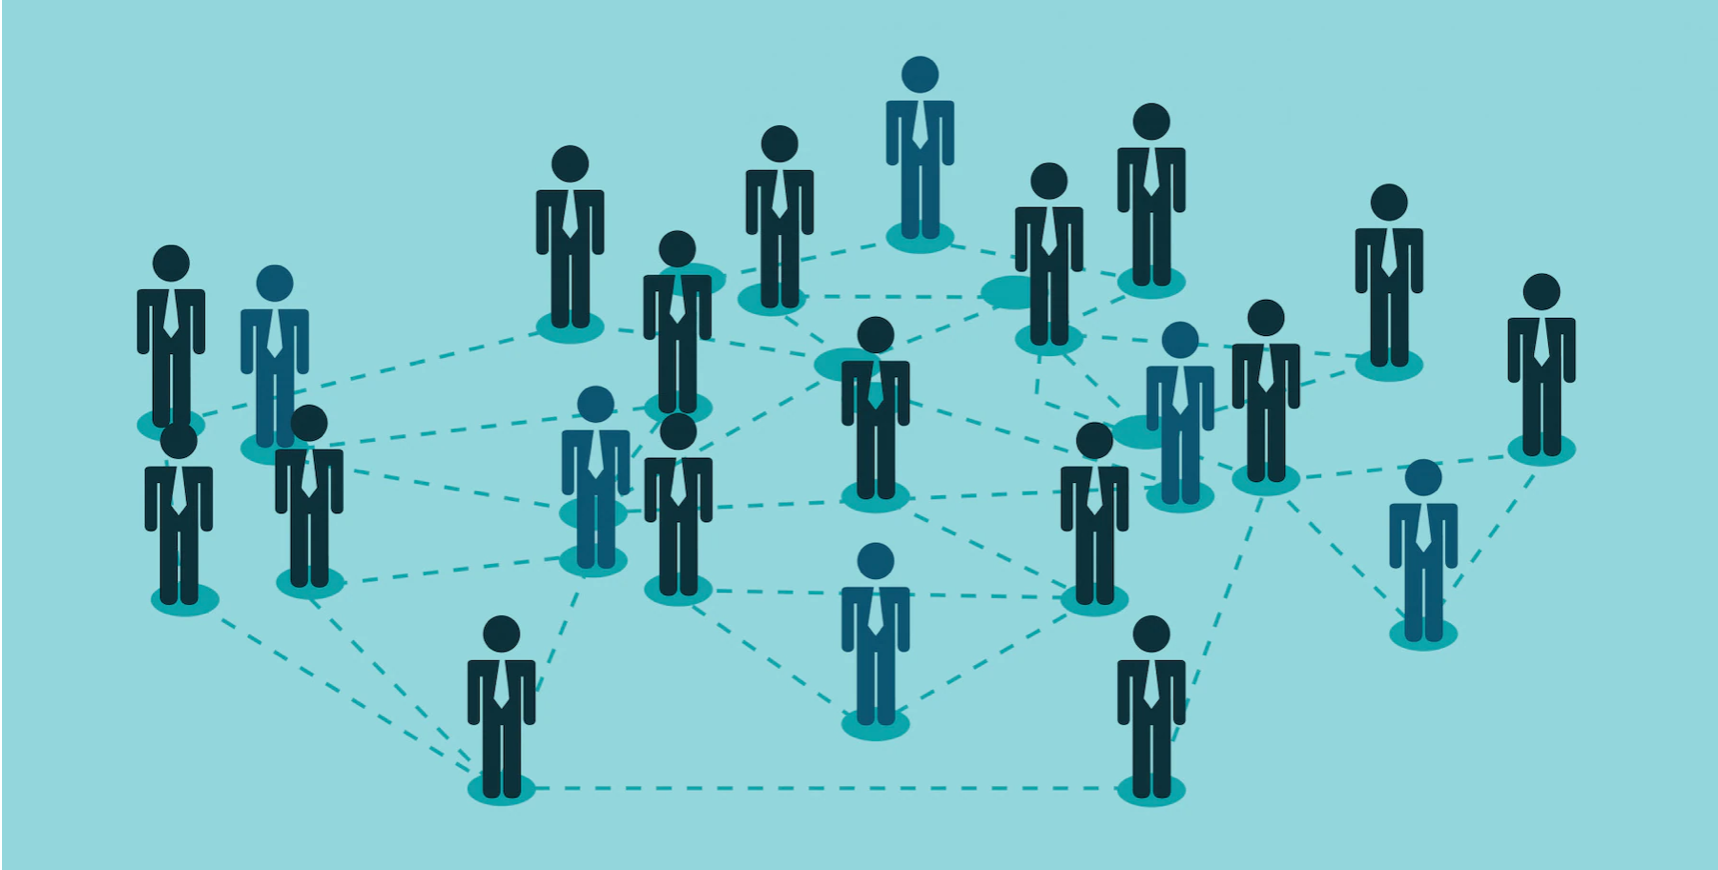

In [103]:
from IPython.display import Image
Image(filename='bg.png') 

# How can the company improve collaboration?

## 📖 Background
You work in the analytics department of a multinational company, and the head of HR wants your help mapping out the company's employee network using message data. 

They plan to use the network map to understand interdepartmental dynamics better and explore how the company shares information. The ultimate goal of this project is to think of ways to improve collaboration throughout the company. 

## 💾 The data

The company has six months of information on inter-employee communication. For privacy reasons, only sender, receiver, and message length information are available [(source)](https://snap.stanford.edu/data/CollegeMsg.html). 

#### Messages has information on the sender, receiver, and time.
- "sender" - represents the employee id of the employee sending the message.
- "receiver" - represents the employee id of the employee receiving the message.
- "timestamp" - the date of the message.
- "message_length" - the length in words of the message.

#### Employees has information on each employee;
- "id" - represents the employee id of the employee.
- "department" - is the department within the company. 
- "location" - is the country where the employee lives.
- "age" - is the age of the employee.

_**Acknowledgments:** Pietro Panzarasa, Tore Opsahl, and Kathleen M. Carley. "Patterns and dynamics of users' behavior and interaction: Network analysis of an online community." Journal of the American Society for Information Science and Technology 60.5 (2009): 911-932._

In [104]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from IPython.display import display

messages = pd.read_csv('data/messages.csv', parse_dates= ['timestamp'])
messages

,sender,receiver,timestamp,message_length
0,79,48,2021-06-02 05:41:34,88
1,79,63,2021-06-02 05:42:15,72
2,79,58,2021-06-02 05:44:24,86
3,79,70,2021-06-02 05:49:07,26
4,79,109,2021-06-02 19:51:47,73
...,...,...,...,...
3507,469,1629,2021-11-24 05:04:57,75
3508,1487,1543,2021-11-26 00:39:43,25
3509,144,1713,2021-11-28 18:30:47,51
3510,1879,1520,2021-11-29 07:27:52,58


In [105]:
employees = pd.read_csv('data/employees.csv')
employees

,id,department,location,age
0,3,Operations,US,33
1,6,Sales,UK,50
2,8,IT,Brasil,54
3,9,Admin,UK,32
4,12,Operations,Brasil,51
...,...,...,...,...
659,1830,Admin,UK,42
660,1839,Admin,France,28
661,1879,Engineering,US,40
662,1881,Sales,Germany,57


In [106]:
df_1 = (pd.merge(messages, employees, left_on = 'sender', right_on = 'id'))

df_2 = (pd.merge(df_1, employees, left_on = 'receiver', right_on = 'id'))

comms = (df_2[['sender','department_x','age_x', 'location_x',
              'receiver','department_y','age_y','location_y',
              'timestamp', 'message_length']])

# Inter-Employee Communications

## Which employees had the most connections?

- The graph shows the top 10 employees who had the largest number of unique fellow employees they have sent messages to and received messages from.
- 9 out of 10 of the list have connections have only sent messages. While only one employee in the top 10 have both sent and received messages.
- Employee No. 144 from the sales department is the most connected employee becaue they have messages connected a total of 73 different employees. All of the messages of employee 144 are sent messages, none are received messages.

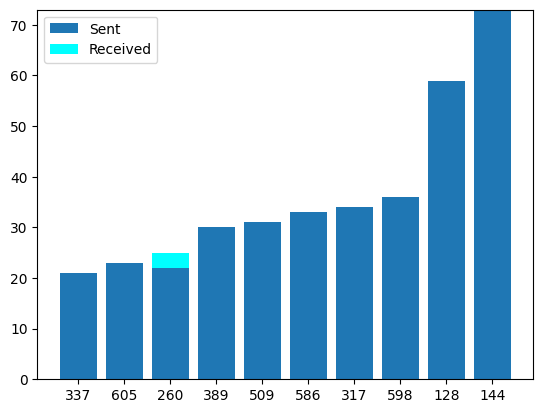

,id,department
4,337,Sales
9,605,Admin
2,260,Operations
5,389,Sales
6,509,Admin
7,586,Operations
3,317,Operations
8,598,Operations
0,128,Sales
1,144,Sales


In [107]:
empl_send = (comms[['sender','receiver','department_x']]
            .drop_duplicates(subset = 'receiver')
        	.groupby('sender', as_index = False)
            .count()
            .sort_values('receiver'))

empl_send['sender'] = empl_send['sender'].apply(str)

empl_rcvd = (comms[['sender','receiver','department_y']]
            .drop_duplicates(subset = 'sender')
            .groupby('receiver',as_index = False)
            .count()
            .sort_values('sender'))
empl_rcvd['receiver'] = empl_rcvd['receiver'].apply(str)

empl_conx = pd.merge(empl_send,empl_rcvd, left_on = 'sender', right_on = 'receiver', how = 'outer').fillna(0)

empl_conx['total_connections'] = empl_conx['receiver_x'] + empl_conx['sender_y']
empl_conx = empl_conx.sort_values('total_connections')

top_conx = empl_conx.tail(10)

fig, ax = plt.subplots()

ax.bar(top_conx['sender_x'], top_conx['receiver_x'])
ax.bar(top_conx['sender_x'], top_conx['sender_y'],
      	bottom = top_conx['receiver_x'],
        color = 'cyan')

ax.legend(['Sent', 'Received'])

plt.show()

top_conx['sender_x'] = top_conx['sender_x'].apply(int)

top_empl_depts = pd.merge(employees, top_conx, left_on = "id", right_on = 'sender_x')
top_empl_depts = top_empl_depts.sort_values('total_connections')

display(top_empl_depts[['id', 'department']])


## Which employees had the most messages?

- This graph shows the top 10 employees with the largest amount of both received and sent messages.
- Although 8 out of 10 of the employees have both sent and received messages, majority of their messages are sent from them.
- Employee no. 605 from the admin department is the most influential employee because they have sent the largest amount of messages with more than 500 messages in total.

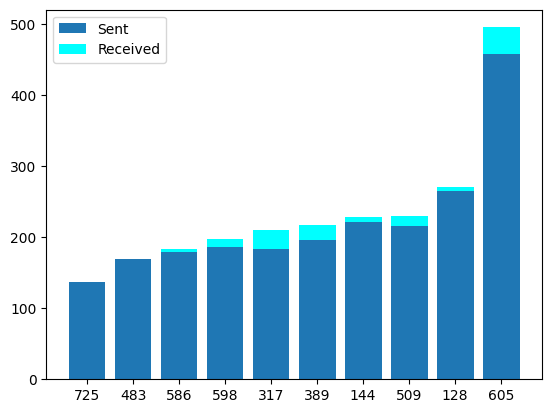

,id,department
9,725,Sales
4,483,Sales
6,586,Operations
7,598,Operations
2,317,Operations
3,389,Sales
1,144,Sales
5,509,Admin
0,128,Sales
8,605,Admin


In [108]:
# How many times an employee appeared on both the sending and receiving end of messages

df_1 = (comms[['sender','receiver']]
            .groupby('sender',as_index = False)
            .count()
            .sort_values('receiver', ascending = False))

df_2 = (comms[['sender','receiver']]
            .groupby('receiver',as_index = False)
            .count()
            .sort_values('sender', ascending = False))

df_3 = pd.merge(df_1,df_2, left_on = 'sender', right_on = 'receiver', how = 'outer').fillna(0)

df_3['sender_x'] = df_3['sender_x'].apply(str).replace(r'\.0$', '', regex=True)
df_3['total_messages'] = df_3['receiver_x'] + df_3['sender_y']

df_3 = df_3.sort_values('total_messages')

top = df_3.tail(10)

fig, ax = plt.subplots()

ax.bar(top['sender_x'], top['receiver_x'])
ax.bar(top['sender_x'], top['sender_y']
       ,bottom = top['receiver_x']
       ,color = 'cyan')

ax.legend(['Sent', 'Received'])

plt.show()

top['sender_x'] = top['sender_x'].apply(int)

top_empl_depts_1 = pd.merge(employees, top, left_on = "id", right_on = 'sender_x')
top_empl_depts_1 = top_empl_depts_1.sort_values('total_messages')
display(top_empl_depts_1[['id', 'department']])

# Inter-Department Communications

## Which department had the most messages?

- The graph shows how many messages were transmitted from and to each department.
- Sales had the largest amount of messages, while operations and admin come in second while having similar amounts.
- Engineering, IT, and Marketing had the least amount of messages with similar amounts.
- Sent and Received Messages Proportions
    - In admin, operations, and sales more more than half of their messages are sent messages. While the other half are received messages. Their departments send messages as much as they receive messages.
    - For IT, engineering, and marketing, 80% of their messages are received messages while the rest are sent messages. These departments receive more messages than they send.

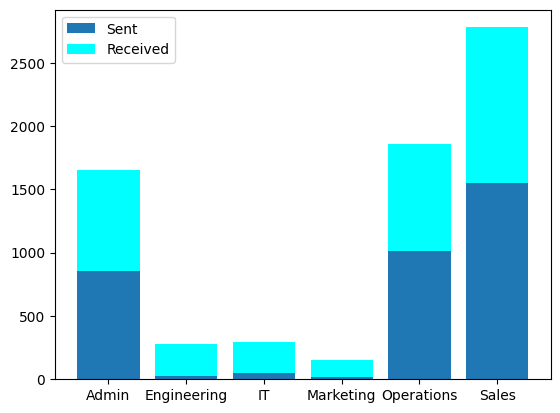

[Text(0, 0, 'Admin'),
 Text(1, 0, 'Engineering'),
 Text(2, 0, 'IT'),
 Text(3, 0, 'Marketing'),
 Text(4, 0, 'Operations'),
 Text(5, 0, 'Sales')]

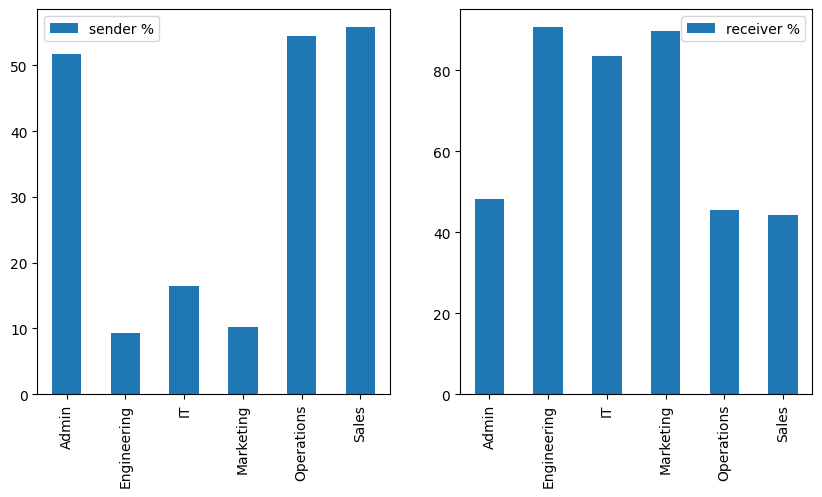

In [109]:
dept_send = (comms[['sender','department_x']]
             .groupby('department_x', as_index = False).count())

dept_rcvd = (comms[['receiver','department_y']]
             .groupby('department_y', as_index = False).count())

fig, ax = plt.subplots()

ax.bar(dept_send['department_x'], dept_send['sender'])
ax.bar(dept_rcvd['department_y'], dept_rcvd['receiver']
       ,bottom = dept_send['sender']
       ,color = 'cyan')

ax.legend(['Sent', 'Received'])

plt.show()

dept_proportions = pd.merge(dept_send,dept_rcvd, left_on = 'department_x', right_on = 'department_y')

dept_proportions['sender %'] = (dept_proportions['sender']/(dept_proportions['sender'] + dept_proportions['receiver']) * 100)

dept_proportions['receiver %'] = (dept_proportions['receiver']/(dept_proportions['receiver'] + dept_proportions['sender']) * 100)

dept_proportions = dept_proportions[['department_x', 'sender','sender %', 'department_y', 'receiver','receiver %']]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize = (10,5))
ticks_x = ['Admin', 'Engineering', 'IT', 'Marketing', 'Operations', 'Sales']
axe = axes.ravel()

ax_0 = dept_proportions[['department_x', 'sender %']].plot(ax=axe[0], kind='bar')
ax_1 = dept_proportions[['department_x', 'receiver %']].plot(ax=axe[1], kind='bar')

ax_0.set_xticklabels(ticks_x)
ax_1.set_xticklabels(ticks_x)

## Which department had the most connections?

- The graph below indicates the employees’ number of contacts they send messages to and receive messages from.
- Employees from the sales department have the largest amount of connections. However, majority of their connections are one way only where they send only send messages. Operations and admin come in second and third respectively and similar sent and received messages proportions to the sales departments. Although these departments have the largest amount of messages both sent and received, the amount of employees they have two way connections with are relatively small.
- Engineering, IT, and marketing employees have a more equal proportion. Despite these departments having the least amount of connections, they have more two-way connections instead of just one way. They relatively receive as much as they send messages

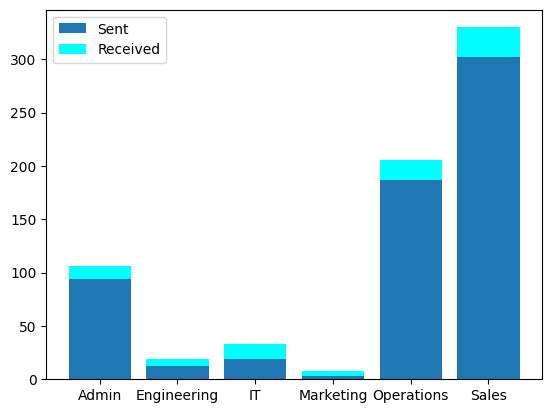

[Text(0, 0, 'Admin'),
 Text(1, 0, 'Engineering'),
 Text(2, 0, 'IT'),
 Text(3, 0, 'Marketing'),
 Text(4, 0, 'Operations'),
 Text(5, 0, 'Sales')]

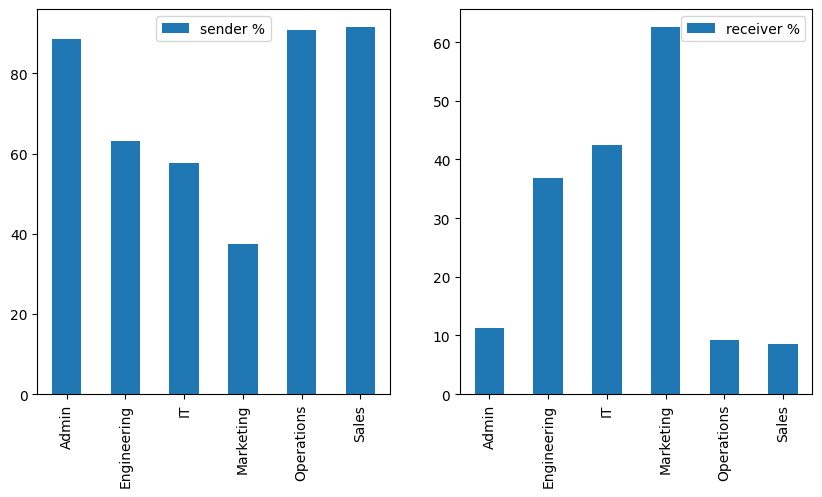

In [110]:
# How many unique connections does employees have in each department

dept_send = (comms[['sender', 'receiver' ,'department_x']]
            .drop_duplicates(subset = 'receiver')
        	.groupby('department_x', as_index = False)
            .count())

dept_rcvd = (comms[['sender', 'receiver' ,'department_y']]
            .drop_duplicates(subset = 'sender')
        	.groupby('department_y', as_index = False)
            .count())

dept_msgs = pd.merge(dept_send, dept_rcvd ,
                     left_on = 'department_x', right_on = 'department_y')

dept_msgs = dept_msgs[['department_x', 'sender_x', 'receiver_y']]
dept_msgs['dept_conx'] = dept_msgs['sender_x'] + dept_msgs['receiver_y']

fig, ax = plt.subplots()

ax.bar(dept_msgs['department_x'], dept_msgs['sender_x'])
ax.bar(dept_msgs['department_x'], dept_msgs['receiver_y']
       ,bottom = dept_msgs['sender_x']
       ,color = 'cyan')

ax.legend(['Sent', 'Received'])

plt.show()

dept_msgs['sender %'] = (dept_msgs['sender_x']/(dept_msgs['sender_x'] + dept_msgs['receiver_y']) * 100)

dept_msgs['receiver %'] = (dept_msgs['receiver_y']/(dept_msgs['sender_x'] + dept_msgs['receiver_y']) * 100)

dept_msgs = dept_msgs[['department_x', 'sender_x','sender %', 'receiver_y','receiver %']]

dept_msgs

fig, axes = plt.subplots(nrows=1, ncols=2, figsize = (10,5))
ticks_x = ['Admin', 'Engineering', 'IT', 'Marketing', 'Operations', 'Sales']
axe = axes.ravel()

ax_0 = dept_msgs[['department_x', 'sender %']].plot(ax=axe[0], kind='bar')
ax_1 = dept_msgs[['department_x', 'receiver %']].plot(ax=axe[1], kind='bar')

ax_0.set_xticklabels(ticks_x)
ax_1.set_xticklabels(ticks_x)

## Who talks to who?

- The graph shows how much a department sends and receives messages from each department including their own.
- The admin department communicates mostly to the sales and operations departments with equal proportions of sent and received messages. They have adequate intradepartmental communications with an equal proportion of sent received messages. The admin department communicates the least with the Engineering, IT, and Marketing departments.
- The engineering department communicates mainly with operations, marketing, and the admin departments however majority of their messages are received messages only. Compared to their other established connections, they do not exhibit strong intradepartmental communications.
- The IT department communicates mainly with the sales, operations, and admin departments. Same with the engineering department, majority of their messages are received only. They also do not exhibit strong intradepartmental communications.
- The marketing department has the least amount of messages, and majority of their messages are also received messages. A huge majority of messages received are from the operations, IT, and admin departments. Sales and engineering only contribute a very small portion to marketing’s messages. Marketing also possess no intradepartmental communications because they send and receive no messages within their own department.
- The operations department communicates mostly with the sales and admin departments where they send as much as they receive messages. They have adequate intradepartmental communications with an equal proportion of sent received messages.
- The sales department has the largest amount of messages. Outside of their department, they communicate mainly with the admin and operations departments. They have the most robust intradepartmental communications with almost equal proportions of sent and received messages.

In [111]:
sales_sent = (comms[comms['department_x'] == 'Sales']
              .groupby('department_y', as_index = False).count())

sales_rcvd = (comms[comms['department_y'] == 'Sales']
              .groupby('department_x', as_index = False).count())

sales_msgs = (pd.merge(sales_sent, sales_rcvd, left_on = 'department_y', right_on = 'department_x', how = 'outer')).fillna(0)
sales_msgs = sales_msgs[['department_y_x', 'sender_x', 'receiver_y']]
sales_msgs.rename(columns = {'sender_x':'Messages Sent to', 
                             'receiver_y':'Messages Received from'}, 
               inplace = True)

# ---------------------------------------------------- #

IT_sent = (comms[comms['department_x'] == 'IT']
              .groupby('department_y', as_index = False).count())

IT_rcvd = (comms[comms['department_y'] == 'IT']
              .groupby('department_x', as_index = False).count())

IT_msgs = (pd.merge(IT_sent, IT_rcvd, left_on = 'department_y', right_on = 'department_x', how = 'outer')).fillna(0)
IT_msgs = IT_msgs[['department_y_x', 'sender_x', 'receiver_y']]
IT_msgs.rename(columns = {'sender_x':'Messages Sent to', 
                             'receiver_y':'Messages Received from'}, 
               inplace = True)

# ---------------------------------------------------- #

admin_sent = (comms[comms['department_x'] == 'Admin']
              .groupby('department_y', as_index = False).count())

admin_rcvd = (comms[comms['department_y'] == 'Admin']
              .groupby('department_x', as_index = False).count())

admin_msgs = (pd.merge(admin_sent, admin_rcvd, left_on = 'department_y', right_on = 'department_x', how = 'outer')).fillna(0)
admin_msgs = admin_msgs[['department_y_x', 'sender_x', 'receiver_y']]
admin_msgs.rename(columns = {'sender_x':'Messages Sent to', 
                             'receiver_y':'Messages Received from'}, 
               inplace = True)

# ---------------------------------------------------- #

engg_sent = (comms[comms['department_x'] == 'Engineering']
              .groupby('department_y', as_index = False).count())

engg_rcvd = (comms[comms['department_y'] == 'Engineering']
              .groupby('department_x', as_index = False).count())

engg_msgs = (pd.merge(engg_sent, engg_rcvd, left_on = 'department_y', right_on = 'department_x', how = 'outer')).fillna(0)
engg_msgs = engg_msgs[['department_y_x', 'sender_x', 'receiver_y']]
engg_msgs.rename(columns = {'sender_x':'Messages Sent to', 
                             'receiver_y':'Messages Received from'}, 
               inplace = True)

# ---------------------------------------------------- #

mktg_sent = (comms[comms['department_x'] == 'Marketing']
              .groupby('department_y', as_index = False).count())

mktg_rcvd = (comms[comms['department_y'] == 'Marketing']
              .groupby('department_x', as_index = False).count())

mktg_msgs = (pd.merge(mktg_sent, mktg_rcvd, left_on = 'department_y', right_on = 'department_x', how = 'outer')).fillna(0)
mktg_msgs = mktg_msgs[['department_y_x', 'sender_x', 'receiver_y']]
mktg_msgs.rename(columns = {'sender_x':'Messages Sent to', 
                             'receiver_y':'Messages Received from'}, 
               inplace = True)

# ---------------------------------------------------- #

ops_sent = (comms[comms['department_x'] == 'Operations']
              .groupby('department_y', as_index = False).count())

ops_rcvd = (comms[comms['department_y'] == 'Operations']
              .groupby('department_x', as_index = False).count())

ops_msgs = (pd.merge(ops_sent, ops_rcvd, left_on = 'department_y', right_on = 'department_x', how = 'outer')).fillna(0)
ops_msgs = ops_msgs[['department_y_x', 'sender_x', 'receiver_y']]
ops_msgs.rename(columns = {'sender_x':'Messages Sent to', 
                             'receiver_y':'Messages Received from'}, 
               inplace = True)

# ---------------------------------------------------- #

[Text(0, 0, 'Admin'),
 Text(1, 0, 'Engineering'),
 Text(2, 0, 'IT'),
 Text(3, 0, 'Marketing'),
 Text(4, 0, 'Operations'),
 Text(5, 0, 'Sales')]

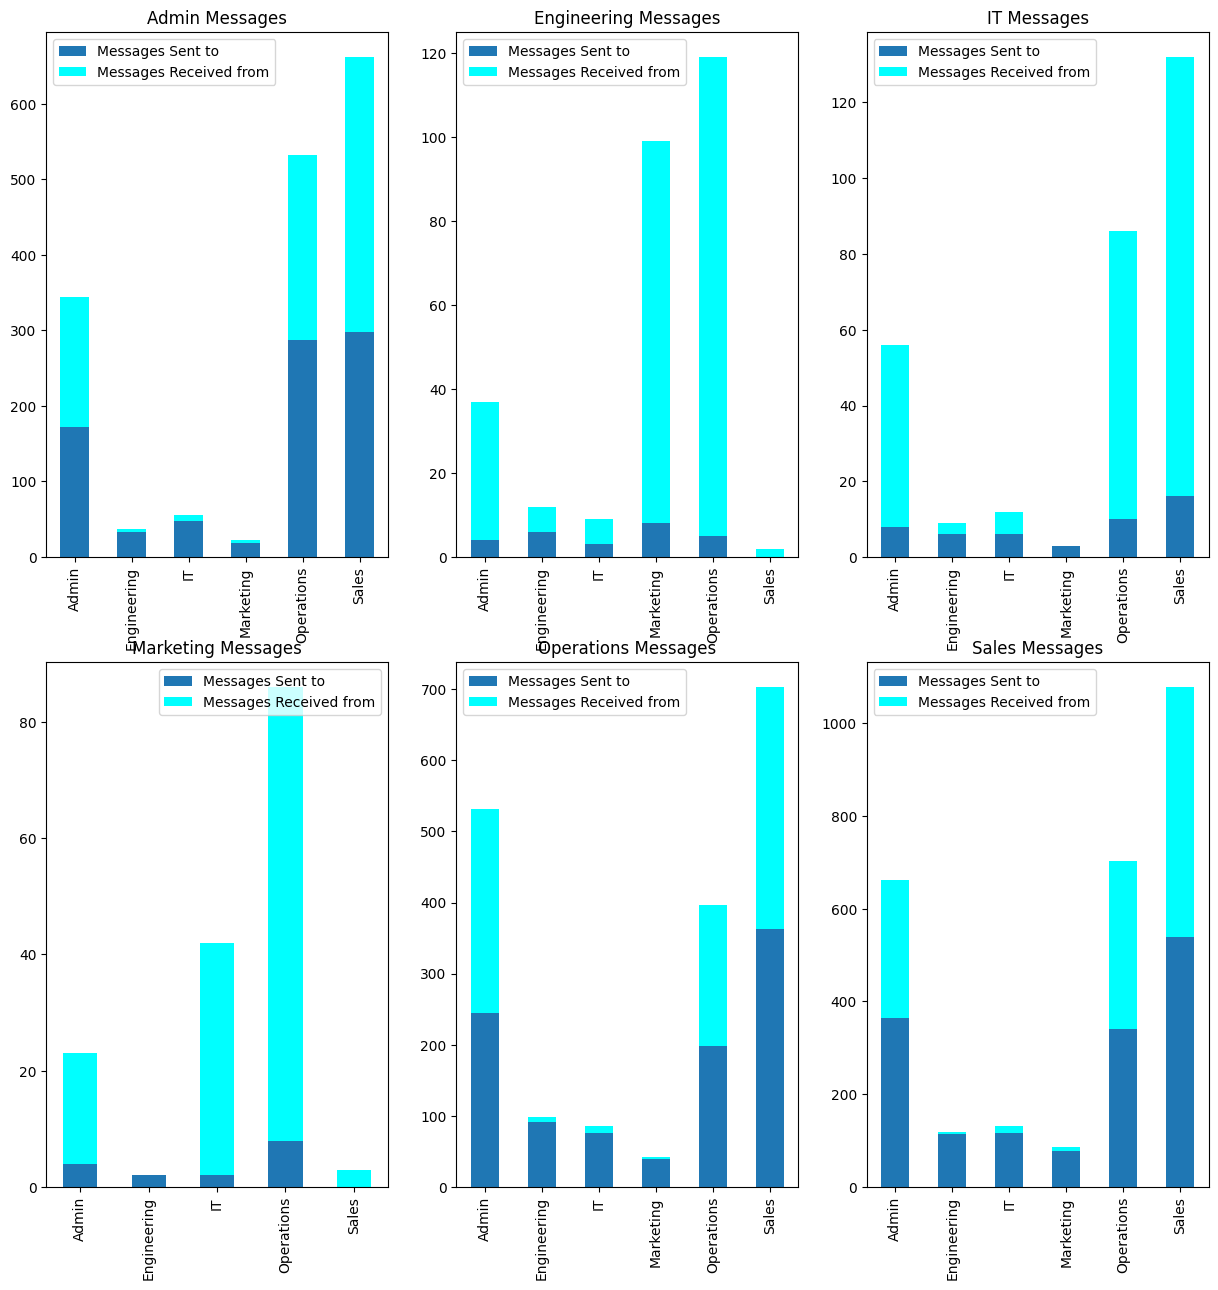

In [112]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize = (15,15))
ticks_x = ['Admin', 'Engineering', 'IT', 'Marketing', 'Operations', 'Sales']
axe = axes.ravel()

ax_0 = admin_msgs[['department_y_x', 'Messages Sent to']].plot(ax=axe[0], kind='bar')
ax_0 = admin_msgs[['department_y_x', 'Messages Received from']].plot(ax=axe[0], kind='bar',
                                                 bottom = admin_msgs['Messages Sent to'],
                                                 color = 'cyan')
ax_0.set_title('Admin Messages')
ax_0.set_xticklabels(ticks_x)

ax_1 = engg_msgs[['department_y_x', 'Messages Sent to']].plot(ax=axe[1], kind='bar')
ax_1 = engg_msgs[['department_y_x', 'Messages Received from']].plot(ax=axe[1], kind='bar',
                                                 bottom = engg_msgs['Messages Sent to'],
                                                 color = 'cyan')
ax_1.set_title('Engineering Messages')
ax_1.set_xticklabels(ticks_x)

ax_2 = IT_msgs[['department_y_x', 'Messages Sent to']].plot(ax=axe[2], kind='bar')
ax_2 = IT_msgs[['department_y_x', 'Messages Received from']].plot(ax=axe[2], kind='bar',
                                                 bottom = IT_msgs['Messages Sent to'],
                                                 color = 'cyan')
ax_2.set_title('IT Messages')
ax_2.set_xticklabels(ticks_x)

ax_3 = mktg_msgs[['department_y_x', 'Messages Sent to']].plot(ax=axe[3], kind='bar')
ax_3 = mktg_msgs[['department_y_x', 'Messages Received from']].plot(ax=axe[3], kind='bar',
                                                 bottom = mktg_msgs['Messages Sent to'],
                                                 color = 'cyan')
ax_3.set_title('Marketing Messages')
ax_3.set_xticklabels(['Admin', 'Engineering', 'IT','Operations', 'Sales'])

ax_4 = ops_msgs[['department_y_x', 'Messages Sent to']].plot(ax=axe[4], kind='bar')
ax_4 = ops_msgs[['department_y_x', 'Messages Received from']].plot(ax=axe[4], kind='bar',
                                                 bottom = ops_msgs['Messages Sent to'],
                                                 color = 'cyan')
ax_4.set_title('Operations Messages')
ax_4.set_xticklabels(ticks_x)

ax_5 = sales_msgs[['department_y_x', 'Messages Sent to']].plot(ax=axe[5], kind='bar')
ax_5 = sales_msgs[['department_y_x', 'Messages Received from']].plot(ax=axe[5], kind='bar',
                                                 bottom = sales_msgs['Messages Sent to'],
                                                 color = 'cyan')
ax_5.set_title('Sales Messages')
ax_5.set_xticklabels(ticks_x)

# Who needs to improve?

## Department in need of improvement
- Engineering Department
- IT Department
- Marketing Department

## They have the least amount of messages.
- The three departments have the least amount of total messages. This is an indicator that they do not communicate as much as the other departments.

## They mostly just receive messages.
- These departments mainly just receive messages which indicates they do not provide that much information to the departments outside of them.

## Almost non-existent intra-departmental collaboration.
- Among all the departments, engineering and IT have the least amount of messages transmitted within their own departments compared to the messages they transmit to other departments.
- Marketing has no message being sent within their own department at all.

# Additional Information

In [113]:
Brasil_sent = (comms[comms['location_x'] == 'Brasil']
              .groupby('location_y', as_index = False).count())

Brasil_rcvd = (comms[comms['location_y'] == 'Brasil']
              .groupby('location_x', as_index = False).count())

Brasil_msgs = (pd.merge(Brasil_sent, Brasil_rcvd, left_on = 'location_y', right_on = 'location_x', how = 'outer')).fillna(0)
Brasil_msgs = Brasil_msgs[['location_y_x', 'sender_x', 'receiver_y']]
Brasil_msgs.rename(columns = {'sender_x':'Messages Sent to', 'receiver_y':'Messages Received from'},
               inplace = True)

# ---------------------------------------------------- #

France_sent = (comms[comms['location_x'] == 'France']
              .groupby('location_y', as_index = False).count())

France_rcvd = (comms[comms['location_y'] == 'France']
              .groupby('location_x', as_index = False).count())

France_msgs = (pd.merge(France_sent, France_rcvd, left_on = 'location_y', right_on = 'location_x', how = 'outer')).fillna(0)
France_msgs = France_msgs[['location_y_x', 'sender_x', 'receiver_y']]
France_msgs.rename(columns = {'sender_x':'Messages Sent to', 'receiver_y':'Messages Received from'}, 
               inplace = True)

# ---------------------------------------------------- #

Germany_sent = (comms[comms['location_x'] == 'Germany']
              .groupby('location_y', as_index = False).count())

Germany_rcvd = (comms[comms['location_y'] == 'Germany']
              .groupby('location_x', as_index = False).count())

Germany_msgs = (pd.merge(Germany_sent, Germany_rcvd, left_on = 'location_y', right_on = 'location_x', how = 'outer')).fillna(0)
Germany_msgs = Germany_msgs[['location_y_x', 'sender_x', 'receiver_y']]
Germany_msgs.rename(columns = {'sender_x':'Messages Sent to', 'receiver_y':'Messages Received from'}, 
               inplace = True)

# ---------------------------------------------------- #

UK_sent = (comms[comms['location_x'] == 'UK']
              .groupby('location_y', as_index = False).count())

UK_rcvd = (comms[comms['location_y'] == 'UK']
              .groupby('location_x', as_index = False).count())

UK_msgs = (pd.merge(UK_sent, UK_rcvd, left_on = 'location_y', right_on = 'location_x', how = 'outer')).fillna(0)

UK_msgs = UK_msgs[['location_y_x', 'sender_x', 'receiver_y']]
UK_msgs.rename(columns = {'sender_x':'Messages Sent to', 'receiver_y':'Messages Received from'}, 
               inplace = True)

# ---------------------------------------------------- #

US_sent = (comms[comms['location_x'] == 'US']
              .groupby('location_y', as_index = False).count())

US_rcvd = (comms[comms['location_y'] == 'US']
              .groupby('location_x', as_index = False).count())

US_msgs = (pd.merge(US_sent, US_rcvd, left_on = 'location_y', right_on = 'location_x', how = 'outer')).fillna(0)
US_msgs = US_msgs[['location_y_x', 'sender_x', 'receiver_y']]
US_msgs.rename(columns = {'sender_x':'Messages Sent to', 'receiver_y':'Messages Received from'}, 
               inplace = True)

# ---------------------------------------------------- #

## Where are messages sent and received?

- The employees span from 5 different countries namely Brasil, France, Germany, UK, and US.
- Most of Brasil's messages are in France and US with majority of their messages being received ones.
- France mainly communiates with the United States and within their own country with equal proportions of sent and received messages.
- Germany has no messages within their country. And majority of their messages are within France and US that is mostly comprised of received messages.
- Majority of UK's messages are from the United States and France. Their messages are mostly comprised of received messages.
- The United States receives and sends the most messages. Their communications are mainly within their own country and France.

[Text(0, 0, 'Brasil'),
 Text(1, 0, 'France'),
 Text(2, 0, 'Germany'),
 Text(3, 0, 'UK'),
 Text(4, 0, 'US')]

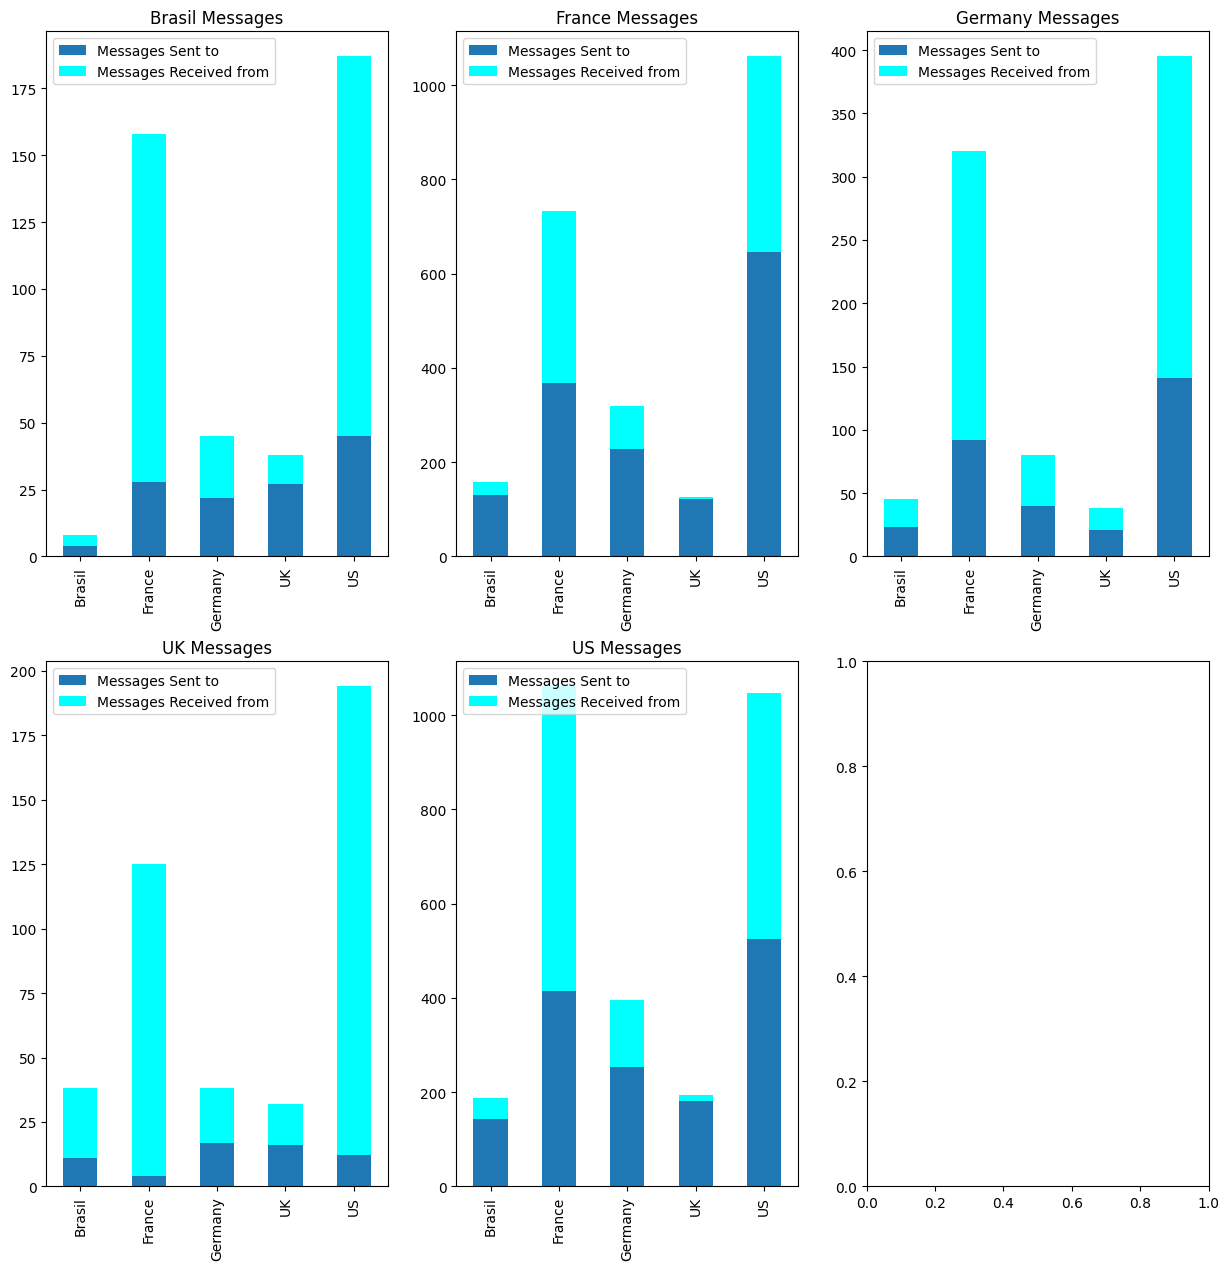

In [114]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize = (15,15))
ticks = ['Brasil', 'France', 'Germany', 'UK', 'US']
axe = axes.ravel()

ax0 = Brasil_msgs[['location_y_x', 'Messages Sent to']].plot(ax=axe[0], kind='bar')
ax0 = Brasil_msgs[['location_y_x', 'Messages Received from']].plot(ax=axe[0], kind='bar',
                                                 bottom = Brasil_msgs['Messages Sent to'],
                                                 color = 'cyan')
ax0.set_title('Brasil Messages')
ax0.set_xticklabels(ticks)

ax1 = France_msgs[['location_y_x', 'Messages Sent to']].plot(ax=axe[1], kind='bar')
ax1 = France_msgs[['location_y_x', 'Messages Received from']].plot(ax=axe[1], kind='bar',
                                                 bottom = France_msgs['Messages Sent to'],
                                                 color = 'cyan')
ax1.set_title('France Messages')
ax1.set_xticklabels(ticks)


ax2 = Germany_msgs[['location_y_x', 'Messages Sent to']].plot(ax=axe[2], kind='bar')
ax2 = Germany_msgs[['location_y_x', 'Messages Received from']].plot(ax=axe[2], kind='bar',
                                                 bottom = Germany_msgs['Messages Sent to'],
                                                 color = 'cyan')
ax2.set_title('Germany Messages')
ax2.set_xticklabels(ticks)

ax3 = UK_msgs[['location_y_x', 'Messages Sent to']].plot(ax=axe[3], kind='bar')
ax3 = UK_msgs[['location_y_x', 'Messages Received from']].plot(ax=axe[3], kind='bar',
                                             	 bottom = UK_msgs['Messages Sent to'],
                                                 color = 'cyan')
ax3.set_title('UK Messages')
ax3.set_xticklabels(ticks)

ax4 = US_msgs[['location_y_x', 'Messages Sent to']].plot(ax=axe[4], kind='bar')
ax4 = US_msgs[['location_y_x', 'Messages Received from']].plot(ax=axe[4], kind='bar',
                                                 bottom = US_msgs['Messages Sent to'],
                                                 color = 'cyan')
ax4.set_title('US Messages')
ax4.set_xticklabels(ticks)


## When are messages sent?

- A bulk of the messages were transmitted in the months of June and August.
- In a week, majority of messages are from Monday to Wednesday. However, there is a significant amount of messages being sent during Sundays.
- In a day, messages are usually sent in the first hours of a working day primarily in around 8 to 9 AM. However, there are also a number of messages sent towards the midnight.

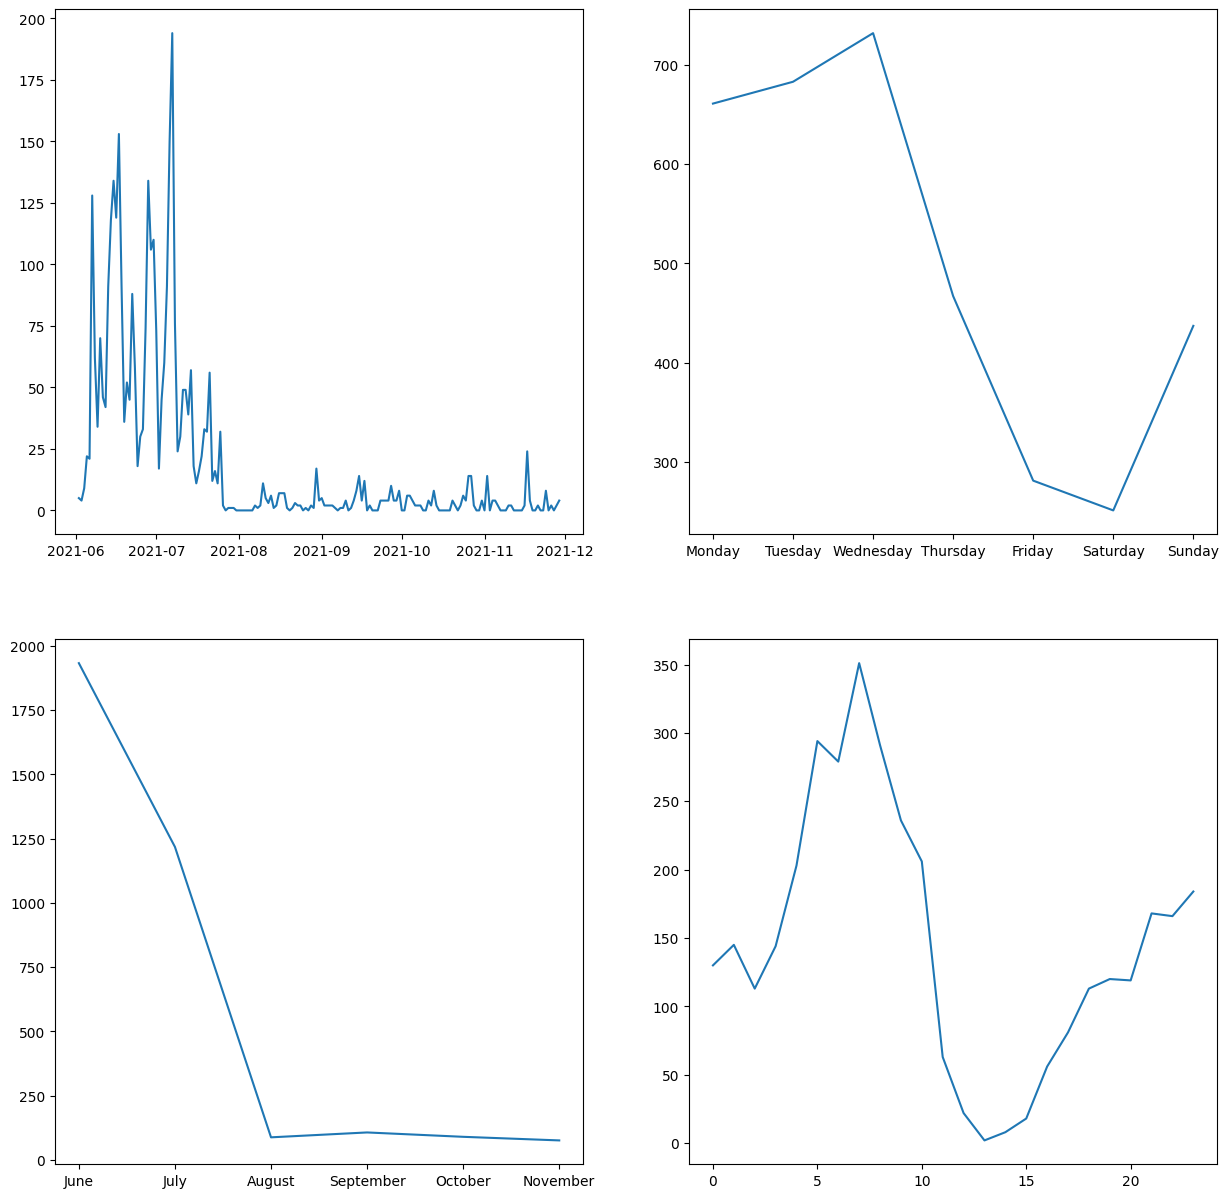

In [115]:
msgs = comms

msgs['day'] = msgs['timestamp'].dt.day_name()
msgs['month'] = msgs['timestamp'].dt.month_name()
msgs['hour'] = msgs['timestamp'].dt.hour

days = (['Monday','Tuesday','Wednesday',
        'Thursday','Friday','Saturday', 'Sunday'])
daily = msgs.groupby('day').count().reindex(days).reset_index()

months = ['June', 'July' ,'August', 'September', 'October', 'November']
monthly = msgs.groupby('month').count().reindex(months).reset_index()

hourly = msgs.groupby('hour').count().reset_index()

overall = msgs.groupby(pd.Grouper(key = 'timestamp', freq = '1D')).count().reset_index()

figure, axis = plt.subplots(2, 2, figsize=(15, 15))

axis[0, 0].plot(overall['timestamp'], overall['sender'])
axis[0, 1].plot(daily['day'], daily['sender'])
axis[1, 0].plot(monthly['month'], monthly['sender'])
axis[1, 1].plot(hourly['hour'], hourly['sender'])